# NEURAL TRANSFER USING PYTORCH
https://pytorch.org/tutorials/advanced/neural_style_tutorial.html

In [1]:
import time
import os
import copy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optims
import torchvision as tv
from PIL import Image

plt.rcParams['figure.figsize'] = [16,8]
plt.ion()  # interactive mode

is_gpu = torch.cuda.is_available()
device = torch.device('cuda:0' if is_gpu else 'cpu')
print(device)

num_workers = os.cpu_count()
print(num_workers)

# Ignore warnings for image input
import warnings
warnings.filterwarnings("ignore")

cuda:0
6


In [2]:
imsize = 512 if is_gpu else 128

In [3]:
resize = tv.transforms.Compose([
    tv.transforms.Resize(imsize),
    tv.transforms.ToTensor()])

def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = resize(image).unsqueeze(0)
    print(image.size())
    return image.to(device, torch.float32)

In [4]:
# style_img_path = os.path.join('.', 'data', 'images', 'picasso.jpg')
# style_img_path = os.path.join('.', 'data', 'images', 'picasso2.jpg')
# style_img_path = os.path.join('.', 'data', 'images', 'van_gogh.jpg')
style_img_path = os.path.join('.', 'data', 'images', 'hanako.jpg')
target_img_path = os.path.join('.', 'data', 'images', 'cat.jpg')

style_img = image_loader(style_img_path)
content_img = image_loader(target_img_path)

assert style_img.size() == content_img.size(), \
    'we need to import style and content images of the same size'

torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])


In [5]:
# from Tensor C x H x W to Numpy.array H x W x C
# similar to tensor.numpy().transpose((1,2,0)) 
tensor2image = tv.transforms.ToPILImage()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)  # remove the fake batch dimension
    image = tensor2image(image)
    plt.imshow(image)

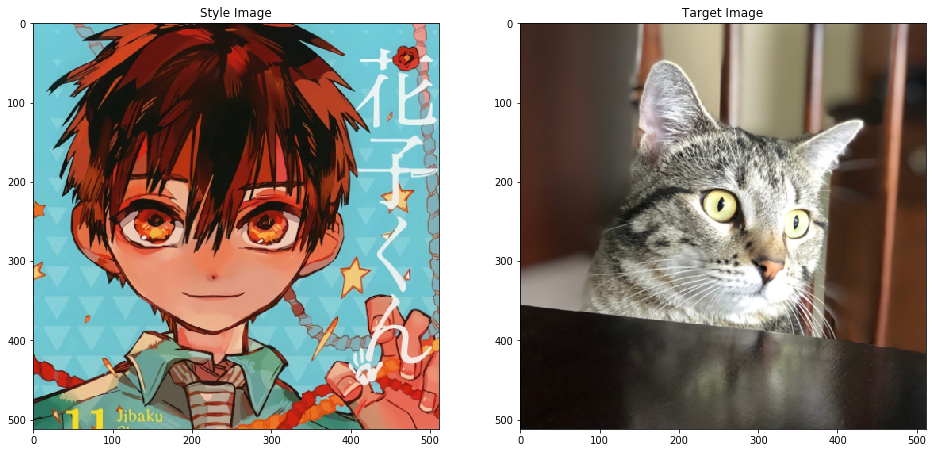

In [6]:
images = [style_img, content_img]
titles = ['Style Image', 'Target Image']
fig = plt.figure()
plt.tight_layout()
for i in range(2):
    ax = plt.subplot(121+i)
    ax.set_title(titles[i])
#     ax.axis('off') 
    imshow(images[i])
plt.show()

In [7]:
class ContentLoss(nn.Module):
    '''Minimize content loss. Use the forward and backpropagation feature in the Module
    '''
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        # detach from graph, same storage
        self.target = target.detach()  
    
    def forward(self, input):
        # minimize the L2 distance between input and target
        self.loss = F.mse_loss(input, self.target)
        return input

In [8]:
def gram_matrix(input):
    batch_size, num_channels, h, w = input.size()
    features = input.view(batch_size*num_channels, h*w)
    G = torch.mm(features, features.t())  # symmetric matrix
    return G.div(batch_size * num_channels * h * w)  # normalize

In [9]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
    
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [10]:
# use pretrained VGG model (19 layers)
# `features`: output individual convo layers
# `eval()`: layers have different behavior during training than evaluation
cnn = tv.models.vgg19(pretrained=True, progress=False).features.to(device).eval()

# mean and std are defined for pretrianed weights
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

print(cnn)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [11]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # `view` reshapes tensor to (C, 1, 1)
        # image has shape of (B,C,H,W)
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)
        
    def forward(self, image):
        return (image - self.mean) / self.std

In [12]:
for layer in cnn.children():
    print(layer)

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True

In [13]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [14]:
def get_style_model_and_losses(
        cnn, 
        norm_mean,
        norm_std,
        style_img,
        content_img,
        content_layers=content_layers_default,
        style_layers=style_layers_default):
    
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(norm_mean, norm_std).to(device)
    
    content_losses = []
    style_losses = []
    
    model = nn.Sequential(normalization)
    
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            print(f'Found {layer.__class__.__name__} layer')
            name = f'bn_{i}'
        else:
            raise RuntimeError(f'Unrecognized layer: {layer.__class__.__name__}')
            
        model.add_module(name, layer)
        
        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)
    
    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    
    model = model[:(i + 1)]
    return model, style_losses, content_losses

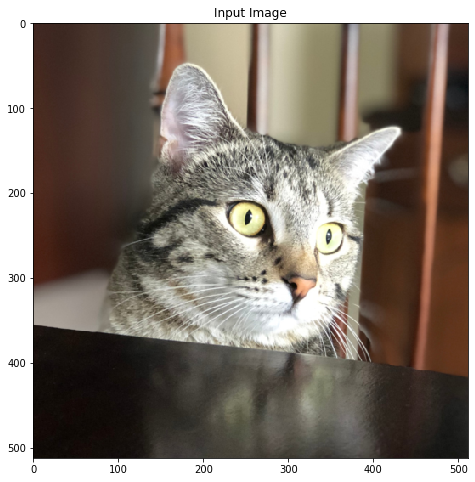

In [15]:
input_img = content_img.clone()
plt.figure()
imshow(input_img)
plt.title('Input Image')
plt.show()

In [16]:
def get_input_optimizer(input_img):
    # Limited-memory BFGS 
    optimizer = optims.LBFGS([input_img.requires_grad_()])
    return optimizer

In [17]:
def run_style_transfer(
        cnn,
        norm_mean,
        norm_std,
        content_img,
        style_img,
        input_img,
        num_steps=300,
        style_weight=1e6,
        content_weight=1):
    
    print('Building the style transfer model...')
    model, style_losses, content_losses = get_style_model_and_losses(
        cnn,
        norm_mean,
        norm_std,
        style_img,
        content_img)
    optimizer = get_input_optimizer(input_img)
    
    print('Optimizing...')
    run = [0]
    while run[0] <= num_steps:
        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            
            style_score = 0
            content_score = 0
            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), 
                    content_score))
                print()

            return style_score + content_score
        
        optimizer.step(closure)
        
    input_img.data.clamp_(0, 1)
    return input_img

In [18]:
output = run_style_transfer(
    cnn,
    cnn_normalization_mean,
    cnn_normalization_std,
    content_img,
    style_img,
    input_img,
    num_steps=500)

Building the style transfer model...
Optimizing...
run [50]:
Style Loss : 690.255127 Content Loss: 23.194929

run [100]:
Style Loss : 73.573532 Content Loss: 24.834896

run [150]:
Style Loss : 32.349525 Content Loss: 24.539322

run [200]:
Style Loss : 18.521093 Content Loss: 24.484266

run [250]:
Style Loss : 11.717533 Content Loss: 24.177299

run [300]:
Style Loss : 7.966749 Content Loss: 23.788879

run [350]:
Style Loss : 5.900914 Content Loss: 23.347218

run [400]:
Style Loss : 4.702746 Content Loss: 22.980120

run [450]:
Style Loss : 3.857837 Content Loss: 22.593290

run [500]:
Style Loss : 3.286114 Content Loss: 22.263601



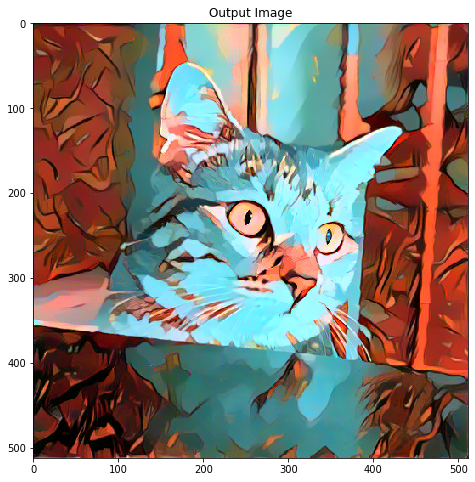

In [19]:
plt.figure()
imshow(output)
plt.title('Output Image')
plt.ioff()
plt.show()